<a href="https://colab.research.google.com/github/anishjohnson/Face-Emotion-Recognition/blob/main/FER/Colab%20Notebook/Face_Emotion_Recognition_Anish_Johnson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Emotion Recognition**










# **Objective**
Our objective is to solve the above mentioned challenge by applying deep learning algorithms to live video data inorder to recognize the facial emotions and categorize them accordingly.

# **Dataset used**
We have utilized the [FER 2013](https://www.kaggle.com/datasets/msambare/fer2013) dataset provided on Kaggle.<br>
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.<br>

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

In [1]:
!nvidia-smi
!nvcc -V

Thu Mar 16 03:58:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Let's Begin:**

# **Data Exploration:**

**Lets start by importing the required libraries.**

In [3]:
# Basic python libraries.
import datetime
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import itertools
import seaborn as sns

# Get rid of warnings!
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries.

from sklearn.metrics import confusion_matrix
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout,BatchNormalization,Activation
from keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

print('Above libraries have been imported.')

Above libraries have been imported.


In [4]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Project-AI/Dataset/FER-2013-Dataset.zip'

In [5]:
 from zipfile import ZipFile
 with ZipFile(file_path , 'r') as ZipFile:
   ZipFile.extractall()
   print('Zip file extracted successfully')

Zip file extracted successfully


**Seperate the Training and Validation Data.**

In [6]:
tf.__version__

'2.11.0'

In [7]:
# Define the train and validataion data paths.
train_dir = '/content/train'
val_dir = '/content/test'

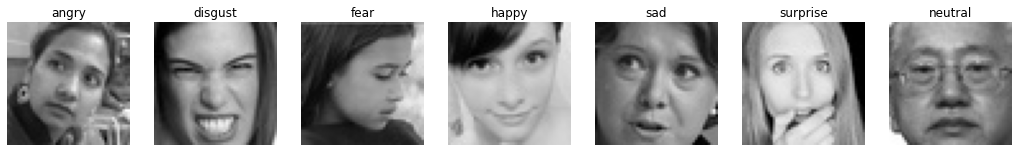

In [8]:
# Define the default image size.
img_size = 48

# Define the seven emotions provided in dataset.
emotion_list = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Plot the images with each distinct emotions.
plt.figure(figsize=(18,22))
i = 1
for expression in emotion_list:
    img = load_img((train_dir + '/' + expression +'/'+ os.listdir(train_dir + '/' + expression)[59]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

**Have a look at our data.**

**Perform some Data Augmentation on train and validations sets.**

# **Data Preprocessing:**

In [9]:
# Rescale the data.
'''
Before we proceed we need to rescale our data by multiplying it to 1/255.
This is done so we get target values between 0 and 1.
'''
# Rescale train data.
datagen_train = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescale validation data.
datagen_val = ImageDataGenerator(rescale = 1./255,
                                 )

print('Above data generator functions have been created.')

Above data generator functions have been created.


In [10]:
# Perform data augmentation.
'''
Data augmentation is a technique to artificially create new training data from existing training data. 
It helps us to increase the size of the dataset and introduce variability in the dataset.
'''
# Define the default image size.
img_size = 48

# Define batch size.
batch_size = 64

                                         
# Train data
train_set = datagen_train.flow_from_directory(
    directory=train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Validation data
val_set = datagen_train.flow_from_directory(
    directory=val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


print('Train and Validation sets have been created.')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Train and Validation sets have been created.


**Now lets create our custom CNN model.**

# **Build CNN Model:**

**Before we start building the neural network lets understand some of the terms that we will be using.**

* **Model = sequential** : A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

* **Padding** = The padding parameter of the Keras Conv2D class can take one of two values: 'valid' or 'same'. Setting the value to “valid” parameter means that the input volume is not zero-padded and the spatial dimensions are allowed to reduce via the natural application of convolution.

* **Activation** = relu :The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.

* **Maxpooling** = Maximum pooling, or max pooling, is a pooling operation that calculates the maximum, or largest, value in each patch of each feature map. The results are down sampled or pooled feature maps that highlight the most present feature in the patch, not the average presence of the feature in the case of average pooling.

* **Batch normalization** = Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

* **Dropout** = Dropout is a technique used to prevent a model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase.

* **Adam** = Adaptive Moment Estimation is an algorithm for optimization technique for gradient descent. The method is really efficient when working with large problem involving a lot of data or parameters. It requires less memory and is efficient. Intuitively, it is a combination of the ‘gradient descent with momentum’ algorithm and the ‘RMSP’ algorithm. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum.

In [11]:
class AlexNet(Sequential):
  def __init__(self, input_shape, num_classes, dropout_rate=0.5):
    super().__init__()

    self.add(Conv2D(64, kernel_size = (3,3),
                    strides= 2, 
                    padding = 'valid', 
                    activation = 'relu',
                    input_shape= input_shape,
                    kernel_initializer= 'he_normal'
                    ))
    
    self.add(MaxPooling2D(pool_size=(3,3), 
                          strides= (2,2),
                          padding= 'valid', 
                          data_format= None))
    
    self.add(Dropout(dropout_rate))

    self.add(Conv2D(128, kernel_size=(3,3), 
                    strides= 1,
                    padding= 'same', 
                    activation= 'relu',
                    kernel_initializer= 'he_normal'))
    
    self.add(MaxPooling2D(pool_size=(3,3), 
                          strides= (2,2),
                          padding= 'valid', 
                          data_format= None)) 

    self.add(Dropout(dropout_rate))

    self.add(Conv2D(256, kernel_size=(3,3), 
                    strides= 1,
                    padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
    
    self.add(MaxPooling2D(pool_size=(3,3), 
                          strides= (2,2),
                          padding= 'valid', 
                          data_format= None)) 

    self.add(Dropout(dropout_rate))

    self.add(Conv2D(512, kernel_size=(3,3), 
                    strides= 1,
                    padding= 'same', 
                    activation= 'relu',
                    kernel_initializer= 'he_normal'))

    self.add(MaxPooling2D(pool_size=(2,2), 
                          strides= (2,2),
                          padding= 'valid', 
                          data_format= None))

    self.add(Dropout(dropout_rate))

    self.add(Flatten())
    self.add(Dense(4096, activation= 'relu'))
    self.add(Dropout(dropout_rate))
    self.add(Dense(4096, activation= 'relu'))
    self.add(Dropout(dropout_rate))
    self.add(Dense(1000, activation= 'relu'))
    self.add(Dropout(dropout_rate))
    self.add(Dense(1000, activation= 'relu'))
    self.add(Dropout(dropout_rate))
    self.add(Dense(1000, activation= 'relu'))
    self.add(Dropout(dropout_rate))
    self.add(Dense(num_classes, activation= 'softmax'))

    opt = SGD(lr=0.01)
    self.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [12]:

class VGGNet(Sequential):
  def __init__(self):
    super().__init__()

    base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

    for layer in base_model.layers[:-4]:
      layer.trainable=False

    self.add(base_model)
    self.add(Dropout(0.5))
    self.add(Flatten())
    self.add(BatchNormalization())
    self.add(Dense(32,kernel_initializer='he_uniform'))
    self.add(BatchNormalization())
    self.add(Activation('relu'))
    self.add(Dropout(0.5))
    self.add(Dense(32,kernel_initializer='he_uniform'))
    self.add(BatchNormalization())
    self.add(Activation('relu'))
    self.add(Dropout(0.5))
    self.add(Dense(32,kernel_initializer='he_uniform'))
    self.add(BatchNormalization())
    self.add(Activation('relu'))
    self.add(Dense(7,activation='softmax'))


    lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

    es = EarlyStopping(verbose=1, patience=20)

    self.compile(optimizer=SGD(lr = 0.001), loss='categorical_crossentropy',metrics=['accuracy'])


In [13]:
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Add, GlobalAveragePooling2D,Dense, Flatten, Conv2D, Lambda,	Input, BatchNormalization, Activation
from tensorflow.keras.optimizers import schedules, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint




class ResNet(Sequential):
  def __init__(self):
    super().__init__()

    base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

    for layer in base_model.layers[:-4]:
        layer.trainable=False
        
    self.add(base_model)
    self.add(Dropout(0.5))
    self.add(Flatten())
    self.add(BatchNormalization())
    self.add(Dense(32,kernel_initializer='he_uniform'))
    self.add(BatchNormalization())
    self.add(Activation('relu'))
    self.add(Dropout(0.5))
    self.add(Dense(32,kernel_initializer='he_uniform'))
    self.add(BatchNormalization())
    self.add(Activation('relu'))
    self.add(Dropout(0.5))
    self.add(Dense(32,kernel_initializer='he_uniform'))
    self.add(BatchNormalization())
    self.add(Activation('relu'))
    self.add(Dense(7,activation='softmax'))


    lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

    es = EarlyStopping(verbose=1, patience=20)

    self.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])


In [15]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

# Define model architecture
model_AlexNet = AlexNet((48,48,3), 7)
model_VGGNet = VGGNet()
model_ResNet = ResNet()
    
# Load weights model
model_AlexNet.load_weights('/content/drive/MyDrive/Project-AI/model_saved/Fer_weights/AlexNetnew_model_weighs_200.h5')
model_VGGNet.load_weights('/content/drive/MyDrive/Project-AI/model_saved/Transfer_weights/VGGNet_weights-50.h5')
model_ResNet.load_weights('/content/drive/MyDrive/Project-AI/model_saved/Transfer_weights/ResNet_weights-50.h5')

alexnet_preds = model_AlexNet.predict(val_set)
vggnet_preds = model_VGGNet.predict(val_set)
resnet_preds = model_ResNet.predict(val_set)


# Concatenate the predictions
combined_pred = np.concatenate((alexnet_preds, vggnet_preds, resnet_preds), axis=1)

svm_model = SVC(kernel='linear')
# Fit the SVM model
svm_model.fit(combined_pred, val_set.classes)
    

TypeError: ignored

#Save model

In [ ]:
import pickle
with open('model.pkl','wb') as f:
    pickle.dump(svm_model,f)


# **Model evaluation:**

In [ ]:
# Load the SVM model
with open('/content/drive/MyDrive/Project-AI/model_saved/Fer_weights/svm_final.pkl', 'rb') as f:
    svm_loaded = pickle.load(f)


In [ ]:
svm_pred = svm_loaded.predict(combined_pred)
# Convert the validation data labels to numeric labels
y_true = val_set.classes

# Convert the SVM predictions to numeric labels
y_pred = svm_pred

# Calculate the accuracy score
accuracy = accuracy_score(y_true, y_pred)

# Print the accuracy score
print("Accuracy:", accuracy)

Accuracy: 0.515881861242686


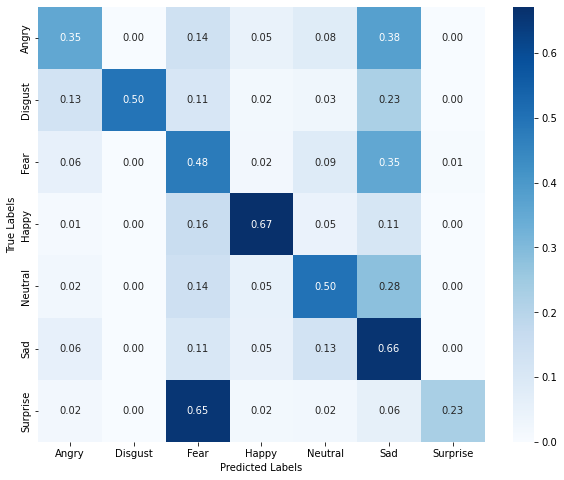

In [ ]:

label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert the values to ratios
cm_ratios = cm / cm.sum(axis=1, keepdims=True)

# Create a plot of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_ratios, annot=True, cmap='Blues', xticklabels=label_dict.values(), yticklabels=label_dict.values(), fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#Load model and predict

In [ ]:
from tensorflow.keras.preprocessing import image

# Load and preprocess the test image
img = image.load_img("/content/test/sad/PrivateTest_22407614.jpg", target_size=(48, 48))
img = image.img_to_array(img)
img = img / 255.0
img = np.expand_dims(img, axis=0)
    
# Obtain predictions from the pre-trained models
alexnet_pred = model_AlexNet.predict(img)
vggnet_pred = model_VGGNet.predict(img)
resnet_pred = model_ResNet.predict(img)
    
# Concatenate the predictions
combined_pred = np.concatenate((alexnet_pred, vggnet_pred, resnet_pred), axis=1)
    
    
# Use the SVM model to predict the class label
    
svm_pred = svm_loaded.predict(combined_pred)
    
predicted_label = label_dict[svm_pred[0]]
print(predicted_label)

1/1 [==============================] - 0s 446ms/step
Angry
